# Example of DOV search methods for observations (observaties)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/DOV-Vlaanderen/pydov/master?filepath=docs%2Fnotebooks%2Fsearch_observaties.ipynb)

## Use cases explained below
* Get observations in a bounding box
* Get observations with specific properties
* Get observations in a bounding box based on specific properties
* Select observations in a municipality and return depth
* Get observations based on fields not available in the standard output dataframee

In [1]:
import os
os.environ['PYDOV_BASE_URL'] = 'https://oefen.dov.vlaanderen.be/'

In [2]:
%matplotlib inline
import inspect, sys
import warnings; warnings.simplefilter('ignore')

In [3]:
# check pydov path
import pydov

## Get information about the datatype 'Observatie'

In [ ]:
from pydov.search.observatie import ObservatieSearch
observatie = ObservatieSearch()

A description is provided for the 'Observatie' datatype:

In [ ]:
observatie.get_description()

The different fields that are available for objects of the 'Observatie' datatype can be requested with the get_fields() method:

In [ ]:
fields = observatie.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

You can get more information of a field by requesting it from the fields dictionary:

* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field
* *codelist*: optionally, a codelist that describes the possible values of this field

Alternatively, you can list all the fields and their details by inspecting the `get_fields()` output or the search instance itself in a notebook:

In [ ]:
observatie

## Example use cases

### Get observations in a bounding box

Get data for all the observations that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [ ]:
from pydov.util.location import Within, Box

df = observatie.search(location=Within(Box(114000, 172310, 114005, 172315, epsg=31370)), max_features = 10)
df.head()

The dataframe contains several observations made at the same location

Using the *pkey_observatie* field one can request the details of these obsevrations in a webbrowser:

In [ ]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

### Get observations with specific properties

Next to querying observations based on their geographic location within a bounding box, we can also search for observations matching a specific set of properties. For this we can build a query using a combination of the 'Observatie' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [ ]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes2'], inspect.isclass) if 'Property' in i]

In this example we build a query using the *PropertyIsEqualTo* operator to find all observations concerning the parameter "Watergehalte (watergehalte)":

In [ ]:
from owslib.fes2 import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='parameter',
                          literal='Watergehalte (watergehalte)')
df = observatie.search(query=query, max_features = 10)

df.head()

Once again we can use the *pkey_observatie* as a permanent link to the information of these observations:

In [ ]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

### Get observations in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the observations within a bounding box that have specific properties.

The following example requests the observations where the parameter 'Watergehalte (watergehalte)' is greater than 30 and within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [ ]:
from owslib.fes2 import PropertyIsGreaterThanOrEqualTo, And

query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='30'),
            PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])

df = observatie.search(
    location=Within(Box(114000, 172310, 114005, 172315, epsg=31370)),
    query=query,
    max_features = 10
    )

df.head()

We can look at one of theobservations in a webbrowser using its *pkey_observatie*:

In [ ]:
for pkey_observatie in set(df.pkey_observatie):
    print(pkey_observatie)

### Select observations with specific conditions and return the results

We can limit the columns in the output dataframe by specifying the *return_fields* parameter in our search.

In this example we query all the observations that have a value (resultaat) greater than 10 for parameter 'Watergehalte (watergehalte)' and	return its value (resultaat):

In [ ]:
query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='10'),
            PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])

df = observatie.search(query=query,
                       return_fields=('resultaat',),
                       max_features=10)
df.head()

In [ ]:
df.describe()

By discarding the observations with a resultaat less than 50, we get a different result:

In [ ]:
df[df.resultaat.astype(float) < 50.0].describe()

In [ ]:
ax = df[df.resultaat.astype(float) < 50.0].astype(float).boxplot()
ax.set_ylabel("Water content(%)");
ax.set_title("Distribution of water content");

### Get observations based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select observations as illustrated below.

For example, make a selection of the observations that have an 'opdracht':

In [ ]:
from owslib.fes2 import Not
from owslib.fes2 import PropertyIsNull

query = Not([PropertyIsNull(propertyname='opdracht')])

df = observatie.search(query=query, max_features = 10,
                   return_fields=('pkey_observatie', 'opdracht'))
df.head()

### Select observations with extra details

We can ask extra info from an observation from the XML. In this example we want the details of an observation

In [ ]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, ObservatieDetails

observatie = ObservatieSearch(
    objecttype=Observatie.with_extra_fields(ObservatieDetails)
)

df = observatie.search(max_features=10)
df.head()

list(df.pkey_observatie)

### Get observations with data from the subtype 'ObservatieHerhaling'

There are different subtypes available within observations search: 'ObservatieHerhaling'



In [ ]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, ObservatieHerhaling
from owslib.fes2 import PropertyIsLike

observatie = ObservatieSearch(
    objecttype=Observatie.with_subtype(ObservatieHerhaling))
query = PropertyIsLike(propertyname='pkey_observatie',
                       literal='%2022-11963810%')
df = observatie.search(query=query, max_features = 10)
df.head()

### Get observations with data from the subtype 'SecundaireParameter'

Another available subtype within observations search: 'SecundaireParameter'

In [ ]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, SecundaireParameter
from owslib.fes2 import PropertyIsLike

observatie = ObservatieSearch(
    objecttype=Observatie.with_subtype(SecundaireParameter))
query = PropertyIsLike(propertyname='pkey_observatie',
                       literal='%2019-000555%')
df = observatie.search(query=query, max_features = 10)
df.head()

## Visualize results

Using Geopandas GeoDataFrame, we can easily display the results of our search on a map.

In [ ]:
import geopandas as gpd

query = And([PropertyIsGreaterThanOrEqualTo(propertyname='resultaat',literal='10'),
             PropertyIsEqualTo(propertyname='parameter', literal='Watergehalte (watergehalte)')])

df = observatie.search(query=query, location=Within(Box(100000, 100000, 500000, 500000, epsg=31370)),
                       return_fields=('pkey_observatie','resultaat','geom'), max_features = 100)

In [ ]:
df

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='EPSG:31370')
gdf.explore()

## Find observations with fraction measurments

Observations of type 'Textuurmeting' contain multiple values per observation: they are the result of fraction measurements and include the different intervals and their respective mass percentage.

While these observations are included when using the standard `ObservatieSearch` class, by default the measurements themselves are not included there. You can include them by adding the `Fractiemeting` subtype:

In [ ]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, Fractiemeting

from owslib.fes2 import PropertyIsEqualTo

search = ObservatieSearch(
    objecttype=Observatie.with_subtype(Fractiemeting)
)

df = search.search(
    query=PropertyIsEqualTo('observatietype', 'Textuurmeting'),
    max_features=1)
df

To make it easier to find the observations with fraction measurements, and immediately retrieve the data, you can use the `ObservatieFractiemetingSearch` class instead. This will return only observations of the type 'Textuurmeting' (hence: containing fraction measurements) and will include the `Fractiemeting` subtype by default:

In [ ]:
from pydov.search.observatie import ObservatieFractiemetingSearch

s = ObservatieFractiemetingSearch()
df = s.search(max_features=1)
df

## Find observations with measurement series

Observations of type 'Meetreeks' contain multiple values per observation: they are the result of a series of measurements and include a list of points (meetpunten) and their corresponding values (meetwaarden). Both the points and the values have a parameter and a unit.

While these observations are included when using the standard `ObservatieSearch` class, by default the measurements themselves are not included there. You can include them by adding the `Meetreeks` subtype:

In [ ]:
from pydov.search.observatie import ObservatieSearch
from pydov.types.observatie import Observatie, Meetreeks

from owslib.fes2 import PropertyIsEqualTo

search = ObservatieSearch(
    objecttype=Observatie.with_subtype(Meetreeks)
)

df = search.search(
    query=PropertyIsEqualTo('observatietype', 'Meetreeks'),
    max_features=1)
df

To make it easier to find the observations with measurement series, and immediately retrieve the data, you can use the `ObservatieMeetreeksSearch` class instead. This will return only observations of the type 'Meetreeks' (hence: containing measurement series) and will include the `Meetreeks` subtype by default:

In [ ]:
from pydov.search.observatie import ObservatieMeetreeksSearch

s = ObservatieMeetreeksSearch()
df = s.search(max_features=1)
df

## Working with water samples and observations

For further analysis and visualisation of the time series data, we can use the data analysis library pandas and visualisation library matplotlib.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

Query the data of a specific filter using its permanent key:

In [ ]:
from pydov.search.monster import MonsterSearch
from pydov.search.observatie import ObservatieSearch

from owslib.fes2 import PropertyIsLike

monster = MonsterSearch()
observatie = ObservatieSearch()

query = PropertyIsLike(
            propertyname='pkey_parents',
            literal='%/data/filter/1991-001040|%')

df_monsters = monster.search(query=query)
df_monsters.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,4-0076-F1/M1/C2013,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2014-02-25,NaN,13.0,vloeistof,Enkelvoudig monster,NaN,[pomp],DE WATERGROEP (VROEGER: VMW - VLAAMSE MAATSCHA...
1,https://oefen.dov.vlaanderen.be/data/monster/2...,4-0076-F1/M2014,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2014-09-30,NaN,13.0,vloeistof,Enkelvoudig monster,NaN,[pomp],EUROFINS
2,https://oefen.dov.vlaanderen.be/data/monster/2...,4-0076-F1/M2015,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2015-09-30,NaN,13.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.
3,https://oefen.dov.vlaanderen.be/data/monster/2...,4-0076-F1/M2016,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2016-07-12,NaN,13.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.
4,https://oefen.dov.vlaanderen.be/data/monster/2...,4-0076-F1/M2017,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2017-03-27,NaN,13.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.


Find the related observations:

In [15]:
from pydov.util.query import Join

df_observaties = observatie.search(
    query=Join(df_monsters, on='pkey_parent', using='pkey_monster')
)

df_observaties.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m,diepte_tot_m,parametergroep,parameter,detectieconditie,resultaat,eenheid,methode,uitvoerder,herkomst
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2009-03-13,NaN,NaN,Fysico-chemische parameters,Redoxpotentiaal (Eh°),NaN,130.000,mV,Onbekend,CHEMIPHAR,LABO
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2009-03-13,NaN,NaN,Anionen,Carbonaat (CO3),<,1.0,mg/l,Onbekend,CHEMIPHAR,LABO
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2009-03-13,NaN,NaN,Zware metalen,Arseen (As),<,5.000,µg/l,Onbekend,CHEMIPHAR,LABO
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2009-03-13,NaN,NaN,Anionen,Nitraat (NO3),<,0.200,mg/l,Onbekend,CHEMIPHAR,LABO
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2009-03-13,NaN,NaN,Anionen,Bicarbonaat (HCO3),NaN,945.6,mg/l,Onbekend,CHEMIPHAR,LABO


The date is still stored as a string type. Transforming to a data type using the available pandas function `to_datetime` and using these dates as row index:

In [17]:
df_observaties['fenomeentijd'] = pd.to_datetime(df_observaties['fenomeentijd'])
df_observaties['resultaat'] = pd.to_numeric(df_observaties['resultaat'])

For many usecases, it is useful to create a pivoted table, showing the value per parameter:

In [18]:
pivot = df_observaties.pivot_table(columns=df_observaties.parameter, values='resultaat', index='fenomeentijd')
pivot

parameter,AfwijkingBalans% (%AfwijkBalans),Aluminium (Al),Ammonium (NH4),Arseen (As),Bicarbonaat (HCO3),Boor (B),Bromide (Br),Cadmium (Cd),Calcium (Ca),Carbonaat (CO3),...,Opgeloste zuurstof (O2),Redoxpotentiaal (Eh°),Som anionen (SomAN),Som kationen (SomKAT),Sulfaat (SO4),Temperatuur (T),Totaal organische koolstof (TOC),Zink (Zn),Zuurtegraad (pH),Zuurtegraad in het labo (pH(Lab.))
fenomeentijd,,,,,,,,,,,,,,,,,,,,,
2006-05-24,NaN,0.050,0.360,5.000,863.4,NaN,NaN,0.500,399.0,NaN,...,0.5,120.0,NaN,NaN,488.0,13.9,58.0,16.0,6.70,NaN
2009-03-13,NaN,NaN,0.370,5.000,945.6,NaN,NaN,0.500,394.7,1.0,...,0.3,130.0,NaN,NaN,431.0,12.7,8.6,10.0,6.76,6.80
2009-12-23,NaN,NaN,0.290,12.467,939.4,NaN,NaN,0.500,447.2,1.0,...,1.0,34.0,NaN,NaN,433.6,10.8,8.9,24.9,7.04,6.90
2011-03-28,NaN,NaN,0.330,12.998,1030.3,NaN,NaN,0.519,331.1,1.0,...,0.3,189.0,NaN,NaN,290.1,12.0,10.0,13.0,6.70,6.90
2011-11-04,NaN,NaN,0.310,8.400,958.3,112.0,NaN,0.500,345.0,1.0,...,0.1,307.0,NaN,NaN,385.5,12.1,8.3,10.9,6.73,7.40
2012-11-26,NaN,NaN,0.310,NaN,976.0,NaN,NaN,NaN,360.0,1.0,...,0.4,179.0,NaN,NaN,313.0,12.7,7.8,NaN,6.61,7.18
2014-02-25,NaN,NaN,0.670,2.000,969.2,100.0,NaN,0.030,330.0,1.0,...,0.2,176.0,NaN,NaN,190.0,12.4,7.5,5.0,6.82,7.10
2014-09-30,NaN,0.020,0.306,2.300,976.0,100.0,NaN,0.030,280.0,1.0,...,0.2,176.0,NaN,NaN,143.2,12.4,5.8,5.0,6.82,6.90
2015-09-30,-6.049,0.049,0.325,5.000,963.8,115.5,NaN,0.500,299.4,1.0,...,0.2,149.5,22.346,19.797,171.2,12.0,9.2,47.3,6.68,6.80


For plotting, the default plotting functionality of Pandas can be used:

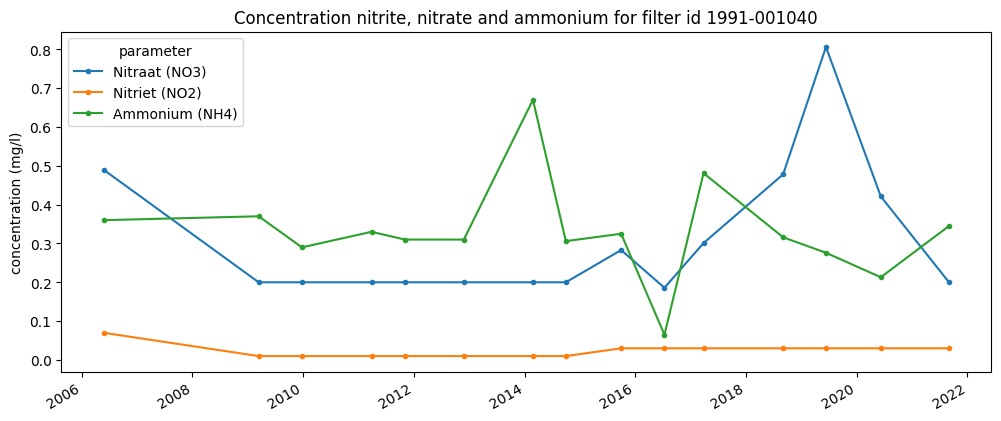

In [21]:
parameters = ['Nitraat (NO3)', 'Nitriet (NO2)', 'Ammonium (NH4)']
ax = pivot[parameters].plot.line(style='.-', figsize=(12, 5))
ax.set_xlabel('');
ax.set_ylabel('concentration (mg/l)');
ax.set_title('Concentration nitrite, nitrate and ammonium for filter id 1991-001040');

### Combine search in filters and samples

For this example, we will first search filters, and later search all samples and observations for this selection. We will select filters in the primary network located in Kalmthout.

In [41]:
from pydov.search.grondwaterfilter import GrondwaterFilterSearch
from pydov.search.monster import MonsterSearch
from pydov.util.query import FuzzyJoin

from owslib.fes2 import And

filter = GrondwaterFilterSearch()
monster = MonsterSearch()

gemeente = 'Kalmthout'
filter_query = And([PropertyIsLike(propertyname='meetnet',
                       literal='meetnet 1 %'),
                    PropertyIsEqualTo(propertyname='gemeente',
                       literal=gemeente)])

df_filters = filter.search(query=filter_query, return_fields=['pkey_filter', 'gw_id', 'filternummer'])
df_filters

[000/001] .


,pkey_filter,gw_id,filternummer
0,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0171,1
1,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0409,1
2,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0409,2
3,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0415,1
4,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0415,2
5,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0415,3
6,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0415,4
7,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0515,1
8,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0710,1
9,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0710,2


Find all samples linked to the filters:

In [42]:
df_monsters = monster.search(
    query=FuzzyJoin(df_filters, on='pkey_parents', using='pkey_filter'))

df_monsters['pkey_filter'] = df_monsters.pkey_parents.apply(lambda x: x[0])
df_monsters = df_monsters.merge(df_filters, on='pkey_filter')

df_monsters.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,pkey_filter,gw_id,filternummer
0,https://oefen.dov.vlaanderen.be/data/monster/2...,1-0171-F1/M2014,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2014-07-17,NaN,27.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Bodemkundige Dienst van België vzw,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0171,1
1,https://oefen.dov.vlaanderen.be/data/monster/2...,1-0171-F1/M2015,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2015-08-26,NaN,27.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0171,1
2,https://oefen.dov.vlaanderen.be/data/monster/2...,1-0171-F1/M2016,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2016-07-05,NaN,27.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0171,1
3,https://oefen.dov.vlaanderen.be/data/monster/2...,1-0171-F1/M2017,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2017-03-10,NaN,27.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0171,1
4,https://oefen.dov.vlaanderen.be/data/monster/2...,1-0171-F1/M2018,[https://oefen.dov.vlaanderen.be/data/filter/1...,grondwater,2018-08-07,NaN,27.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0171,1


Find all NH4 observations linked to the samples:

In [44]:
df_observaties = observatie.search(query=And([
    Join(df_monsters, on='pkey_parent', using='pkey_monster'),
    PropertyIsEqualTo('parameter', 'Ammonium (NH4)'),
    PropertyIsEqualTo('herkomst', 'LABO')
]))
df_observaties = df_observaties.merge(df_monsters, left_on='pkey_parent', right_on='pkey_monster')

df_observaties.head()

[000/001] .


,pkey_observatie,pkey_parent,fenomeentijd,diepte_van_m_x,diepte_tot_m_x,parametergroep,parameter,detectieconditie,resultaat,eenheid,...,diepte_van_m_y,diepte_tot_m_y,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,pkey_filter,gw_id,filternummer
0,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2018-06-27,NaN,NaN,Kationen,Ammonium (NH4),NaN,0.518,mg/l,...,NaN,82.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0410,3
1,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2007-08-03,NaN,NaN,Kationen,Ammonium (NH4),NaN,1.040,mg/l,...,NaN,75.2,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0515,1
2,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2021-06-15,NaN,NaN,Kationen,Ammonium (NH4),NaN,0.539,mg/l,...,NaN,86.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0710,3
3,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2013-08-01,NaN,NaN,Kationen,Ammonium (NH4),NaN,1.040,mg/l,...,NaN,75.2,vloeistof,Enkelvoudig monster,NaN,[pomp],Bodemkundige Dienst van België vzw,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0515,1
4,https://oefen.dov.vlaanderen.be/data/observati...,https://oefen.dov.vlaanderen.be/data/monster/2...,2017-03-10,NaN,NaN,Kationen,Ammonium (NH4),NaN,0.193,mg/l,...,NaN,27.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Analytico B.V.,https://oefen.dov.vlaanderen.be/data/filter/19...,1-0171,1


And plot the results:

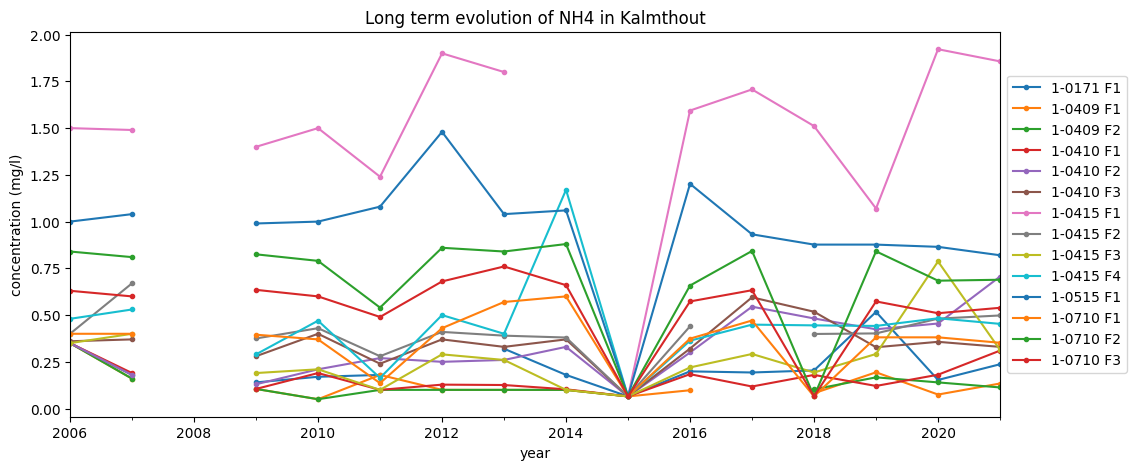

In [45]:
df_observaties['fenomeentijd'] = pd.to_datetime(df_observaties['fenomeentijd'])
df_observaties['resultaat'] = pd.to_numeric(df_observaties['resultaat'])

trends_sel = df_observaties.set_index('fenomeentijd')
trends_sel['label'] = trends_sel['gw_id'] + ' F' + trends_sel['filternummer']

# By pivoting, we get each location in a different column
trends_sel_pivot = trends_sel.pivot_table(columns='label', values='resultaat', index='fenomeentijd')
# trends_sel_pivot.index = pd.to_datetime(trends_sel_pivot.index)

# resample to yearly values and plot data
ax = trends_sel_pivot.resample('A').median().plot.line(style='.-', figsize=(12, 5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title(f'Long term evolution of NH4 in {gemeente}');
ax.set_xlabel('year');
ax.set_ylabel('concentration (mg/l)');